


$ H = - \frac{d^2}{dx^2} + V_0 \exp{(-x^2)}$


$H\Psi = E\Psi$

Задачи:
- Найти энергию основного состояния методом ортогональных коллокаций



In [ ]:
# Пятидиагональная матрица

In [1]:
from tokenize import Double
import numpy as np
import time
from scipy.sparse import diags
from scipy.linalg import eigh_tridiagonal
from scipy.linalg import eig
from scipy.linalg import eigvals
from matplotlib import pyplot as plt

rightRoot = 1 / np.sqrt(3)
leftRoot = - rightRoot


def getPotentialValue(x: np.double, v_0: np.double) -> np.double:
    return (-1) * v_0 * np.exp(-1 * (x * x), dtype=np.double)

def makeDiffMatrix(n: int, R: np.double, v_0: np.double) -> np.ndarray:
    delta = 2*R / (n-1)
    diagonal = np.zeros(n, dtype=np.double)
    subDiagonal = np.ones(n-1, dtype=np.double) * (-1) / (delta * delta)
    
    xs = np.linspace(-R, R, n, dtype=np.double)
    
    for i in range(n):
        diagonal[i] = 2 / (delta * delta) + getPotentialValue(xs[i], v_0)

    # return diags([diagonal, subDiagonal, subDiagonal], [0, -1, 1])  
    return (diagonal, subDiagonal)

# Project point from [-1, 1] interval on interval [leftBorder, rightBorder]
def projectOnInterval(leftBorder: float, rightBorder: float, point: float) -> float:
    delta = abs(rightBorder - leftBorder)
    return leftBorder + ( (1 + point) / 2 ) * delta


# Коэффициенты в полиноме в порядке возрастания степени
def splineValue(coefs: np.ndarray, point: float) -> float:
    res = 0.0
    x_powered = 1
    for coef in coefs:
        res += coef * x_powered
        x_powered = x_powered * point
    return res

#TODO
def splineValueDeriv(coefs: np.ndarray, point: float) -> float:
    res = 0.0
    for i in range(len(coefs)):
        res += i * coefs[i] * pow(point, i)
    return res

#TODO 
def splineValueDerivDeriv(coefs: np.ndarray, point: float) -> float:
    res = 0.0
    x_powered = 1
    for coef in coefs:
        res += coef * x_powered
        x_powered = x_powered * point
    return res



def phi(k, x, xs):
    delta = abs(xs[1] - xs[0])
    if x > xs[k] - delta and x <= xs[k]:
        return -2/delta**3 * (x-xs[k])**3 - 3/delta**2 * (x-xs[k])**2 + 1
    elif x > xs[k] and x <= xs[k] + delta:
        return 2/delta**3 * (x-xs[k])**3 - 3/delta**2 * (x-xs[k])**2 + 1
    else:
        return 0.0
    
def psi(k, x, xs):
    delta = abs(xs[1] - xs[0])
    if x > xs[k] - delta and x <= xs[k]:
        return 1/delta**2 * (x-xs[k])**3 + 2/delta * (x-xs[k])**2 + (x-xs[k])
    elif x > xs[k] and x <= xs[k] + delta:
        return 1/delta**2 * (x-xs[k])**3 - 2/delta * (x-xs[k])**2 + (x-xs[k])
    else:
        return 0.0



def phi_derivderiv(k, x, xs):
    delta = abs(xs[1] - xs[0])
    if x > xs[k] - delta and x <= xs[k]:
        return -12/delta**3 * (x-xs[k]) - 6/delta**2 
    elif x > xs[k] and x <= xs[k] + delta:
        return 12/delta**3 * (x-xs[k]) - 6/delta**2 
    else:
        return 0.0

    
def psi_derivderiv(k, x, xs):
    delta = abs(xs[1] - xs[0])
    if x > xs[k] - delta and x <= xs[k]:
        return 6/delta**2 * (x-xs[k]) + 4/delta 
    elif x > xs[k] and x <= xs[k] + delta:
        return 6/delta**2 * (x-xs[k]) - 4/delta
    else:
        return 0.0


def S_basis(k, x, xs):
    delta = abs(xs[1] - xs[0])
    if k == 0 or k == 2 * len(xs):
        return psi(k//2, x, xs)
    elif k % 2 == 1:
        return psi((k+1)//2, x, xs)
    else:
        return phi(k//2, x, xs)

def S_basis_derivderiv(k, x, xs):
    delta = abs(xs[1] - xs[0])
    if k == 0 or k == 2 * len(xs):
        return psi_derivderiv(k//2, x, xs)
    elif k % 2 == 1:
        return psi_derivderiv((k+1)//2, x, xs)
    else:
        return phi_derivderiv(k//2, x, xs)


In [2]:
numberOfPoints = 5
boxBorder = 10
potential = 5

x_ks = np.linspace(-boxBorder, boxBorder, numberOfPoints)
collocationsPoints = []
for i in range(numberOfPoints - 1):
    collocationsPoints.append(projectOnInterval(x_ks[i], x_ks[i + 1], leftRoot))
    collocationsPoints.append(projectOnInterval(x_ks[i], x_ks[i + 1], rightRoot))

print(x_ks)
print(collocationsPoints)

[-10.  -5.   0.   5.  10.]
[-8.943375672974064, -6.0566243270259355, -3.9433756729740645, -1.0566243270259355, 1.0566243270259355, 3.9433756729740645, 6.0566243270259355, 8.943375672974064]


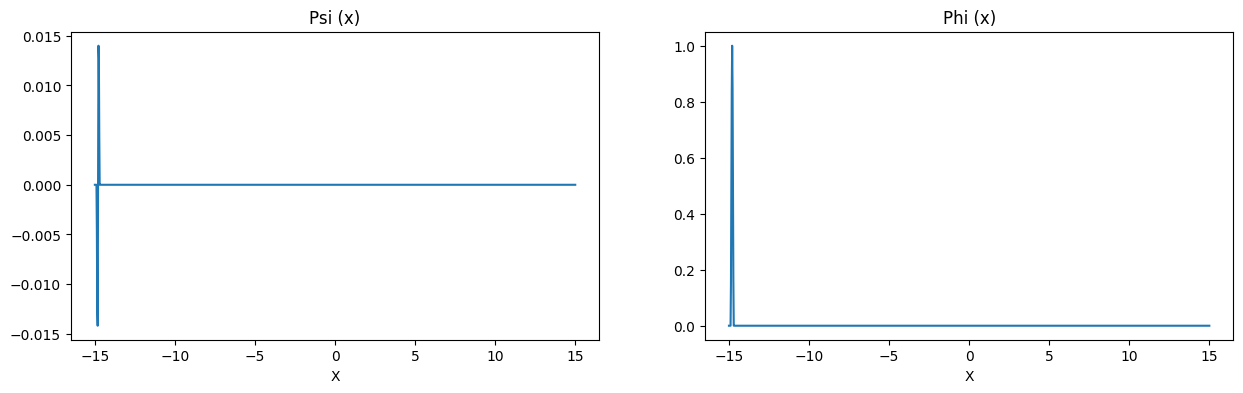

In [54]:
numberOfPoints = 300
boxBorder = 15
potential = 5

delta = 2 * boxBorder / (numberOfPoints - 1) 
xs = np.linspace(-boxBorder, boxBorder, numberOfPoints)
xs_plot = np.linspace(-boxBorder, boxBorder, numberOfPoints*4)
xs_collocations = np.zeros(2 * (numberOfPoints - 1))

for idx, value in enumerate(xs[:-1]):
    xs_collocations[idx*2] = value + delta/2 * (1 - 1/np.sqrt(3))
    xs_collocations[idx*2 + 1] = value + delta/2 * (1 + 1/np.sqrt(3))

ys_psi = np.zeros_like(xs_plot)
ys_phi = np.zeros_like(xs_plot)

for idx, value in enumerate(xs_plot):
    ys_psi[idx] = S_basis(3, value, xs)
    ys_phi[idx] = S_basis(4, value, xs)


fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 4))
axes[0].plot(xs_plot, ys_psi)
axes[0].set_xlabel("X")
axes[0].set_title("Psi (x)")
axes[1].plot(xs_plot, ys_phi)
axes[1].set_xlabel("X")
axes[1].set_title("Phi (x)")
# plt.savefig(("Psi_Phi.png"), dpi=300, bbox_inches='tight')
plt.show()

1  :   [-0.3539918078300856]
2  :   [-0.9547798729717937]
3  :   [-1.6414652391632942, -0.007294986761927474]
4  :   [-2.3754387120231772, -0.1508553511999182]
5  :   [-3.140333480015128, -0.40611987916196834]
6  :   [-3.9274399874843136, -0.739778899556237]
7  :   [-4.731483655897836, -1.1313185841428692]
8  :   [-5.548988374187147, -1.5678361384223192]
9  :   [-6.377521912842036, -2.0406039677302963, -0.0012335010291408335]
10  :   [-7.215304586675115, -2.543396091809608, -0.0791526658007651]
11  :   [-8.060988165921247, -3.0715877538096477, -0.21924742334819758]


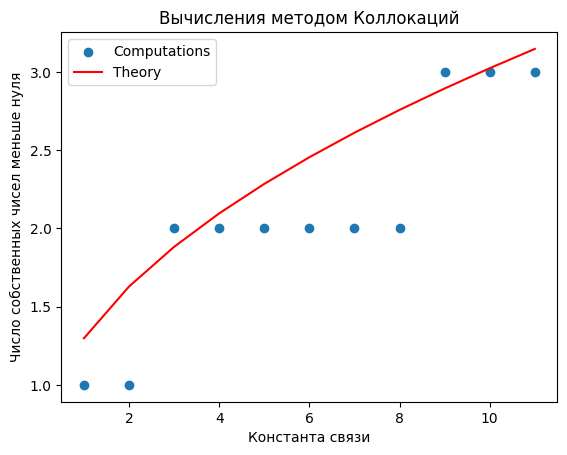

In [64]:
numberOfPoints = 300
boxBorder = 15
# potentials = [0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
potentials = [*range(1,12)]
nStatStates = []

xs = np.linspace(-boxBorder, boxBorder, numberOfPoints)
for V_0 in potentials:
    matr = np.zeros((2*(numberOfPoints - 1), 2*(numberOfPoints - 1)))
    helper = np.zeros_like(matr)

    for i in range(2*(numberOfPoints - 1)):
        for j in range(2*(numberOfPoints - 1)):
            matr[i][j] = -1 * S_basis_derivderiv(i, xs_collocations[j], xs) + getPotentialValue(xs_collocations[j], V_0) * S_basis(i, xs_collocations[j], xs)
            helper[i][j] = S_basis(i, xs_collocations[j], xs)

    eigValues = np.sort(eigvals(a=matr, b=helper))
    goodValues = []
    for value in eigValues.real:
        if value < 0.0 :
            goodValues.append(value) 
    print(V_0, " :  ", goodValues[:5])
    # statState = (w < 0).sum()
    nStatStates.append(len(goodValues))
    

plt.scatter(potentials, nStatStates, label='Computations')
Ns = [2 * np.sqrt(x/ (2 * np.pi)) + 1/2 for x in potentials]
plt.plot(potentials, Ns, color='r', label='Theory')
plt.xlabel("Константа связи")
plt.ylabel("Число собственных чисел меньше нуля")
plt.title("Вычисления методом Коллокаций")
plt.legend()
plt.savefig(("ConstantColl.png"), dpi=300, bbox_inches='tight')
plt.show()

3.0  :   [-0.29230334  0.88603355  2.17873459  4.09761225  6.56360559]
4.0  :   [-0.33741025  0.50132875  1.16397645  2.26227157  3.64141585]
5.0  :   [-0.34919435  0.3259875   0.70464856  1.43148866  2.29662806]
6.0  :   [-0.35256085  0.23029426  0.4636957   0.9891479   1.56920977]
7.0  :   [-0.35355975  0.17189775  0.32432835  0.72616062  1.13311116]
8.0  :   [-0.35386076  0.13345973  0.2377189   0.55691537  0.85241687]
9.0  :   [-0.35395201  0.10673562  0.18080348  0.44137813  0.66199752]
10.0  :   [-0.35397974  0.08736795  0.14168     0.35884935  0.52742705]
19  :   [-0.35399181  0.02550294  0.03333654  0.10257008  0.13138041]
30  :   [-0.35399157  0.01048286  0.01243364  0.04199667  0.0495379 ]
50  :   [-0.35398969  0.00384123  0.0042551   0.01537042  0.01700597]
100  :   [-0.35395676  0.00097345  0.0010244   0.003894    0.00409719]
200  :   [-3.46441262e-01  2.44942734e-04  2.51437566e-04  9.79776993e-04
  1.00573726e-03]
500  :   [-1.87178528e-01  3.92773991e-05  3.98975364e-05 

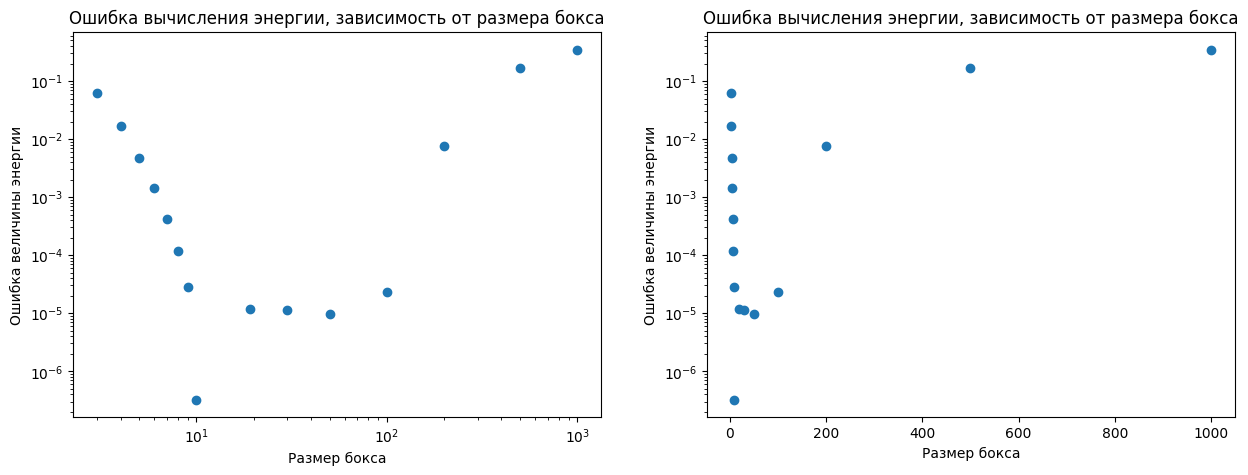

In [5]:
numberOfPoints = 300
boxBorders = [ 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 19, 30, 50, 100, 200, 500, 1000]
# potentials = [0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
potential = 1.0
nStatStates = []
gsEnergies = []
errDecreases = []

prevEnergy = 0.0
for boxBorder in boxBorders:
    xs = np.linspace(-boxBorder, boxBorder, numberOfPoints)
    xs_collocations = np.zeros(2 * (numberOfPoints - 1))
    delta = 2 * boxBorder / (numberOfPoints - 1) 

    for idx, value in enumerate(xs[:-1]):
        xs_collocations[idx*2] = value + delta/2 * (1 - 1/np.sqrt(3))
        xs_collocations[idx*2 + 1] = value + delta/2 * (1 + 1/np.sqrt(3))
        
    matr = np.zeros((2*(numberOfPoints - 1), 2*(numberOfPoints - 1)))
    helper = np.zeros_like(matr)

    for i in range(2*(numberOfPoints - 1)):
        for j in range(2*(numberOfPoints - 1)):
            matr[i][j] = -1 * S_basis_derivderiv(i, xs_collocations[j], xs) + getPotentialValue(xs_collocations[j], potential) * S_basis(i, xs_collocations[j], xs)
            helper[i][j] = S_basis(i, xs_collocations[j], xs)

    eigValues = np.sort(eigvals(a=matr, b=helper))
    w = eigValues.real

    print(boxBorder, " :  ", w[:5])
    # statState = (w < 0).sum()
    nStatStates.append(len(w))
    if len(w) > 0:
        gsEnergies.append(w[0])
    else:
        gsEnergies.append(0)
    # errDecreases.append(abs(w[0] - prevEnergy))
    errDecreases.append(abs(w[0] - (-0.35398006)))
    prevEnergy = w[0]
    # plt.plot(xs, getPotentialValue(xs, V_0))

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
axes[0].scatter(boxBorders, errDecreases)
axes[0].set_xlabel("Размер бокса")
axes[0].set_ylabel("Ошибка величины энергии")
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title("Ошибка вычисления энергии, зависимость от размера бокса")
axes[1].scatter(boxBorders, errDecreases)
axes[1].set_xlabel("Размер бокса")
axes[1].set_ylabel("Ошибка величины энергии")
axes[1].set_yscale('log')
axes[1].set_title("Ошибка вычисления энергии, зависимость от размера бокса")
plt.savefig(("Error_box_size_coll.png"), dpi=300, bbox_inches='tight')
plt.show()


20  :   [-0.30210351  0.0226042   0.03040001  0.09105961  0.11970129]
30  :   [-0.34498187  0.02298517  0.02990937  0.09240389  0.118064  ]
50  :   [-0.35384554  0.02309062  0.02979438  0.09280335  0.11765327]
100  :   [-0.35398733  0.02309121  0.02979251  0.09280546  0.11764608]
200  :   [-0.35399157  0.02309117  0.02979246  0.09280532  0.11764587]
300  :   [-0.3539918   0.02309117  0.02979246  0.09280532  0.11764585]
500  :   [-0.35399185  0.02309117  0.02979245  0.09280531  0.11764585]
1000  :   [-0.35399186  0.02309117  0.02979245  0.09280531  0.11764585]


TypeError: 'int' object is not subscriptable

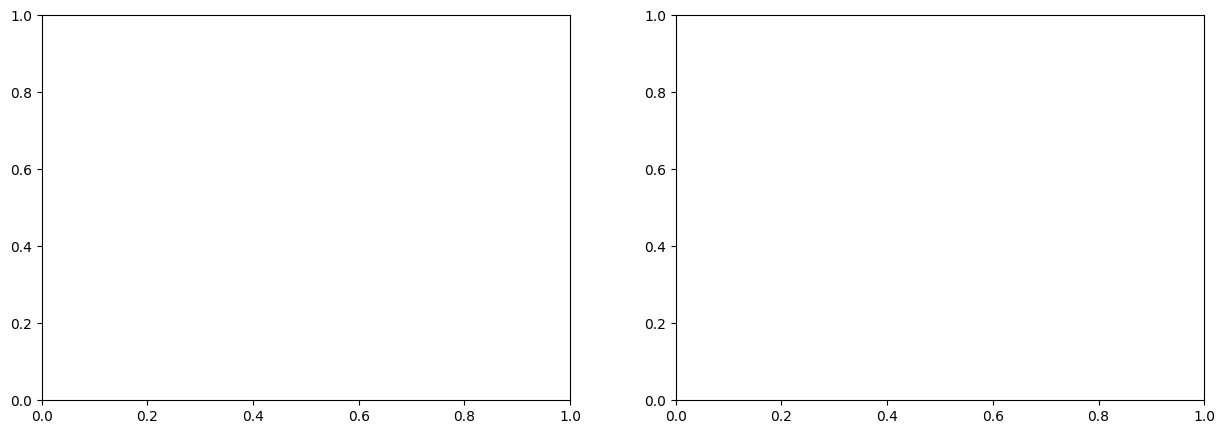

In [2]:
numberOfPointses = [20, 30, 50, 100, 200, 300, 500, 1000, ]
boxBorder = 20
potential = 1
nStatStates = []
computationalTimes = []
errDecreases = []

prevEnergy = 0.0
for numberOfPoints in numberOfPointses:
    start_time = time.time()
    xs = np.linspace(-boxBorder, boxBorder, numberOfPoints)
    xs_collocations = np.zeros(2 * (numberOfPoints - 1))
    delta = 2 * boxBorder / (numberOfPoints - 1) 

    for idx, value in enumerate(xs[:-1]):
        xs_collocations[idx*2] = value + delta/2 * (1 - 1/np.sqrt(3))
        xs_collocations[idx*2 + 1] = value + delta/2 * (1 + 1/np.sqrt(3))
        
    matr = np.zeros((2*(numberOfPoints - 1), 2*(numberOfPoints - 1)))
    helper = np.zeros_like(matr)

    for i in range(2*(numberOfPoints - 1)):
        for j in range(2*(numberOfPoints - 1)):
            matr[i][j] = -1 * S_basis_derivderiv(i, xs_collocations[j], xs) + getPotentialValue(xs_collocations[j], potential) * S_basis(i, xs_collocations[j], xs)
            helper[i][j] = S_basis(i, xs_collocations[j], xs)

    eigValues = np.sort(eigvals(a=matr, b=helper))
    w = eigValues.real

    res_time = time.time() - start_time
    computationalTimes.append(res_time)

    print(numberOfPoints, " :  ", w[:5])
    # statState = (w < 0).sum()
    nStatStates.append(len(w))


    errDecreases.append(abs(w[0] - (-0.35398006)))
    prevEnergy = w[0]

    


    # plt.plot(xs, getPotentialValue(xs, V_0))

# plt.scatter(numberOfPoints, nStatStates)
# plt.xscale('log')
# plt.show()
# print("Изменения энергии основного состояния по сравнению с предыдущим шагом: ", end=' ')
# print(errDecreases)
# plt.plot(numberOfPoints, errDecreases)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel("Число точек сетки")
# plt.ylabel("Изменение энергии основного состояния")
# plt.show()

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
axes[0].scatter(numberOfPoints[:-1], errDecreases[:-1])
axes[0].set_xlabel("Число точек сетки")
axes[0].set_ylabel("Ошибка величины энергии")
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title("Ошибка вычисления энергии, зависимость от числа точек")
axes[1].scatter([2*boxBorder / x for x in numberOfPoints[:-1]], errDecreases[:-1])
axes[1].set_xlabel("Шаг сетки")
axes[1].set_ylabel("Ошибка величины энергии")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title("Ошибка вычисления энергии, зависимость от шага сетки")
plt.savefig(("Error_net_size_coll.png"), dpi=300, bbox_inches='tight')
plt.show()


fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
axes[0].scatter(numberOfPoints, computationalTimes)
axes[0].set_xlabel("Число точек сетки")
axes[0].set_ylabel("Затраченное время")
# axes[0].set_xscale('log')
# axes[0].set_yscale('log')
axes[0].set_title("Затраченное время, зависимость от числа точек")
axes[1].scatter([2*boxBorder / x for x in numberOfPoints], computationalTimes)
axes[1].set_xlabel("Шаг сетки")
axes[1].set_ylabel("Затраченное время")
# axes[1].set_xscale('log')
# axes[1].set_yscale('log')
axes[1].set_title("Затраченное время, зависимость от шага сетки")
plt.savefig(("Time_net_size_2_coll.png"), dpi=300, bbox_inches='tight')
plt.show()
# plt.scatter(numberOfPoints, computationalTimes)
# # plt.xscale('log')
# # plt.yscale('log')
# plt.xlabel("Число точек сетки")
# plt.ylabel("Затраченное время")
# plt.xscale('log')
# plt.show()


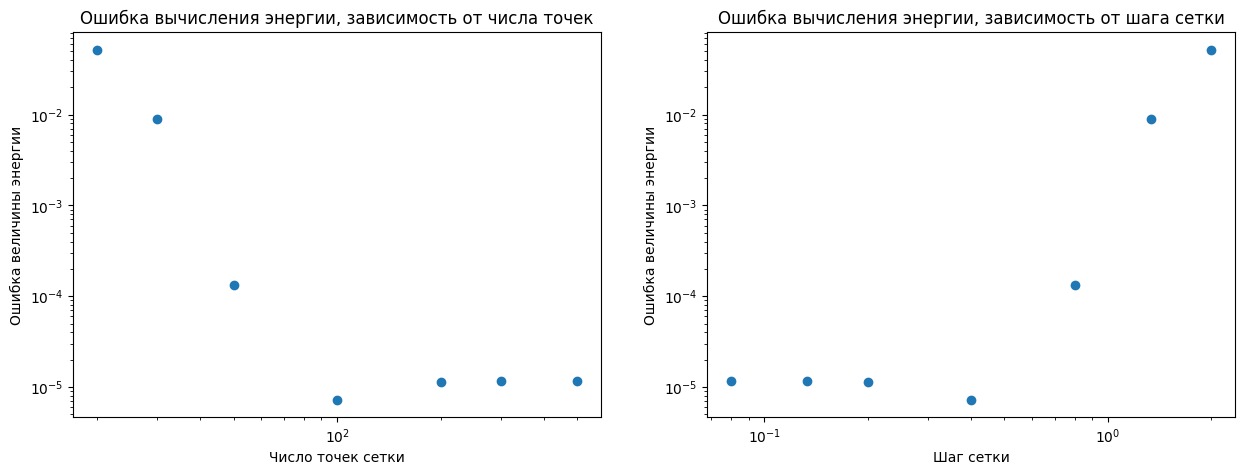

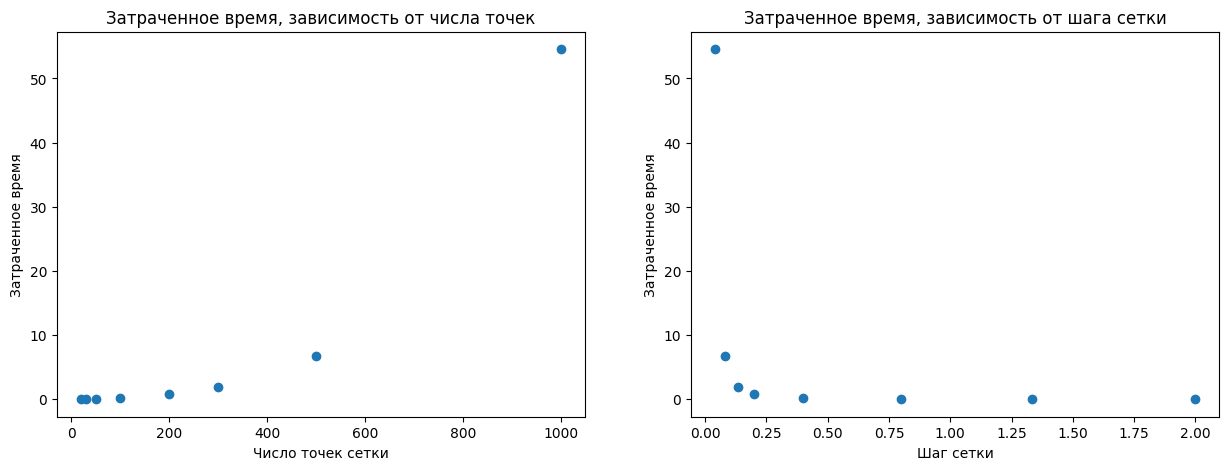

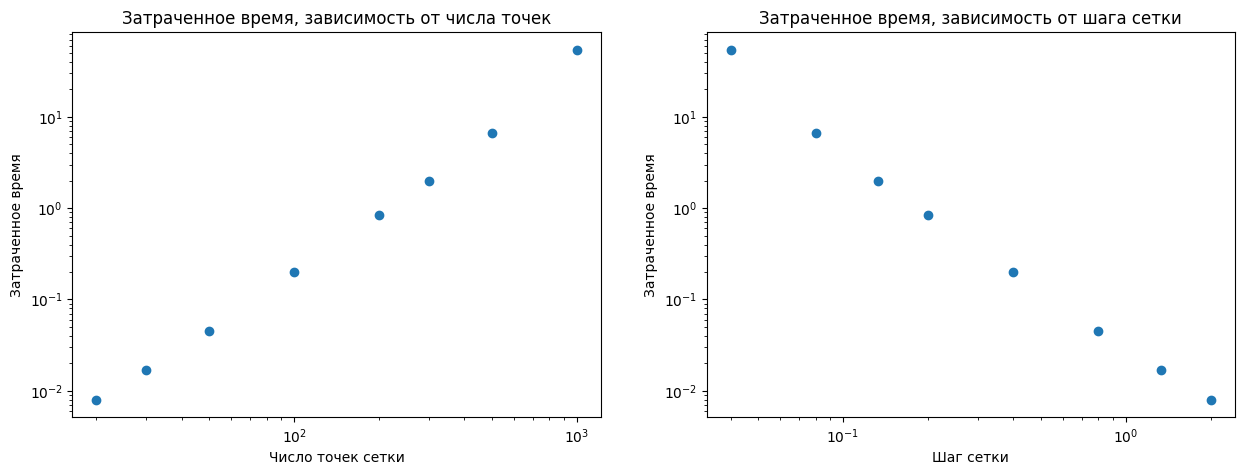

2.370008259139163


In [5]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
axes[0].scatter(numberOfPointses[:-1], errDecreases[:-1])
axes[0].set_xlabel("Число точек сетки")
axes[0].set_ylabel("Ошибка величины энергии")
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title("Ошибка вычисления энергии, зависимость от числа точек")
axes[1].scatter([2*boxBorder / x for x in numberOfPointses[:-1]], errDecreases[:-1])
axes[1].set_xlabel("Шаг сетки")
axes[1].set_ylabel("Ошибка величины энергии")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title("Ошибка вычисления энергии, зависимость от шага сетки")
plt.savefig(("Error_net_size_coll.png"), dpi=300, bbox_inches='tight')
plt.show()


fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
axes[0].scatter(numberOfPointses, computationalTimes)
axes[0].set_xlabel("Число точек сетки")
axes[0].set_ylabel("Затраченное время")
# axes[0].set_xscale('log')
# axes[0].set_yscale('log')
axes[0].set_title("Затраченное время, зависимость от числа точек")
axes[1].scatter([2*boxBorder / x for x in numberOfPointses], computationalTimes)
axes[1].set_xlabel("Шаг сетки")
axes[1].set_ylabel("Затраченное время")
# axes[1].set_xscale('log')
# axes[1].set_yscale('log')
axes[1].set_title("Затраченное время, зависимость от шага сетки")
plt.savefig(("Time_net_size_2_coll.png"), dpi=300, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
axes[0].scatter(numberOfPointses, computationalTimes)
axes[0].set_xlabel("Число точек сетки")
axes[0].set_ylabel("Затраченное время")
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title("Затраченное время, зависимость от числа точек")
axes[1].scatter([2*boxBorder / x for x in numberOfPointses], computationalTimes)
axes[1].set_xlabel("Шаг сетки")
axes[1].set_ylabel("Затраченное время")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title("Затраченное время, зависимость от шага сетки")
plt.savefig(("Time_net_size_coll.png"), dpi=300, bbox_inches='tight')
plt.show()


timesLog = np.log10(computationalTimes)
dotsLog = np.log10(numberOfPointses)

print((timesLog[-1] - timesLog[2])/( dotsLog[-1] - dotsLog[2] ))